<h2 align=center>Analyze Worldwide Box Office Revenue with Plotly and Python</h2>


### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
from urllib.request import urlopen
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

[nltk_data] Downloading package stopwords to /home/rhyme/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


###  Data Loading and Exploration

In [ ]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [ ]:
train.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,Keywords,revenue,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,production_company_Regency Enterprises,production_company_BBC Films,production_company_Dune Entertainment,production_company_Working Title Films,production_company_Fox Searchlight Pictures,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films,num_countries,production_country_United States of America,production_country_United Kingdom,production_country_France,production_country_Germany,production_country_Canada,production_country_India,production_country_Italy,production_country_Japan,production_country_Australia,production_country_Russia,production_country_Spain,production_country_China,production_country_Hong Kong,production_country_Ireland,production_country_Belgium,production_country_South Korea,production_country_Mexico,production_country_Sweden,production_country_New Zealand,production_country_Netherlands,production_country_Czech Republic,production_country_Denmark,production_country_Brazil,production_country_Luxembourg,production_country_South Africa,num_languages,language_English,language_Français,language_Español,language_Deutsch,language_Pусский,language_Italiano,language_日本語,language_普通话,language_हिन्दी,language_,language_Português,language_العربية,language_한국어/조선말,language_广州话 / 廣州話,language_தமிழ்,language_Polski,language_Magyar,language_Latin,language_svenska,language_ภาษาไทย,language_Český,language_עִבְרִית,language_ελληνικά,language_Türkçe,language_Dansk,language_Nederlands,language_فارسی,language_Tiếng Việt,language_اردو,language_Română,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,genders_0_cast,genders_1_cast,genders_2_cast,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank,num_crew,crew_name_Avy Kaufman,crew_name_Robert Rodriguez,crew_name_Deborah Aquila,crew_name_James Newton Howard,crew_name_Mary Vernieu,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James Horner,crew_name_Kerry Barden,crew_name_Bob Weinstein,crew_name_Harvey Weinstein,crew_name_Janet Hirshenson,genders_0_crew,genders_1_crew,genders_2_crew,jobs_

### (Part 1) Visualizing the Target Distribution

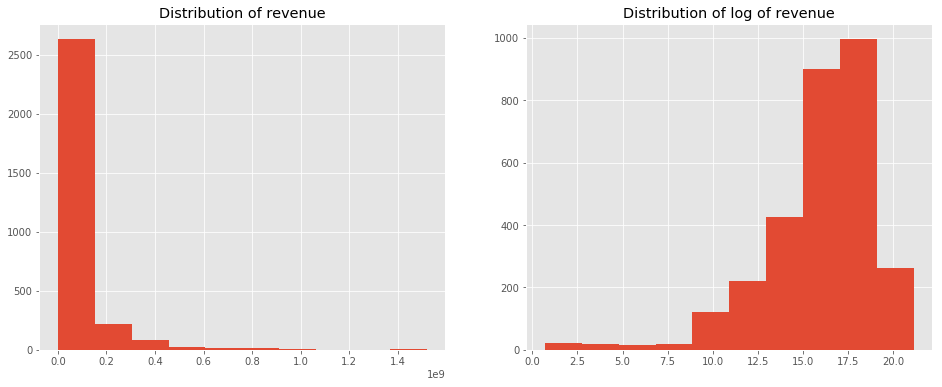

In [ ]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['revenue']);
plt.title('Distribution of revenue');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['revenue']));
plt.title('Distribution of log of revenue');

In [ ]:
train['log_revenue'] = np.log1p(train['revenue'])

### Relationship between Film Revenue and Budget

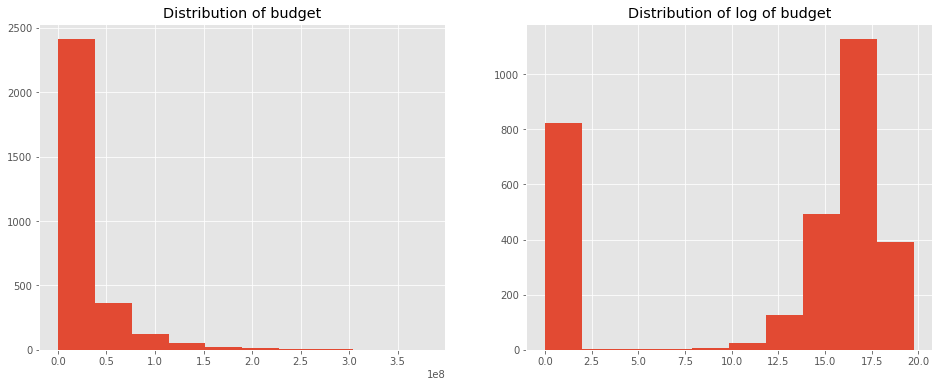

In [ ]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['budget']);
plt.title('Distribution of budget');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['budget']));
plt.title('Distribution of log of budget');

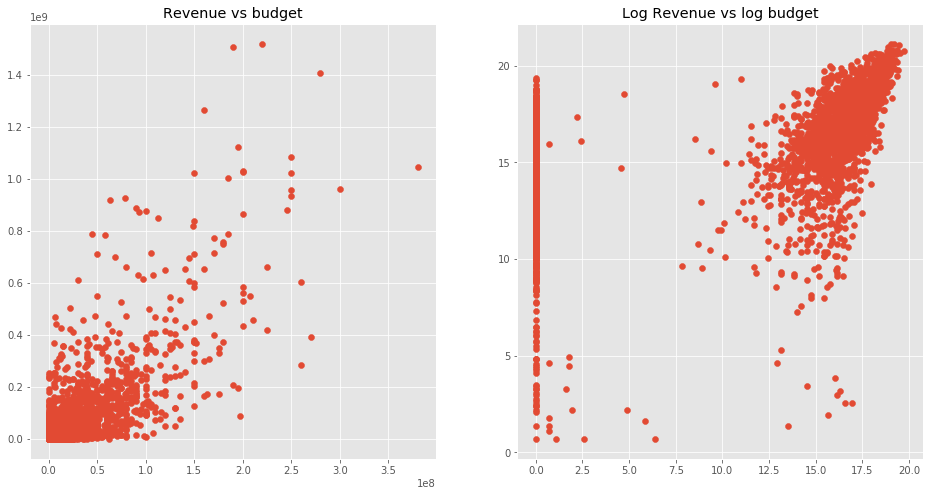

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['budget'], train['revenue'])
plt.title('Revenue vs budget');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget']), train['log_revenue'])
plt.title('Log Revenue vs log budget');

In [ ]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

### Does having an Official Homepage Affect Revenue?

In [ ]:
train['homepage'].value_counts().head(10)

http://www.transformersmovie.com/                                     4
http://www.lordoftherings.net/                                        2
http://www.thehobbit.com/                                             2
http://www.harshtimes.com/                                            1
http://dragontattoofilm.com/about-5/the-girl-who-played-with-fire/    1
http://www.warriorfilm.com/index2.html                                1
http://www.jankypromoters.com/                                        1
http://www.teamamerica.com                                            1
http://www.letmein-movie.com                                          1
http://www.dineshdsouza.com/movies/hillarys-america/                  1
Name: homepage, dtype: int64

In [ ]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

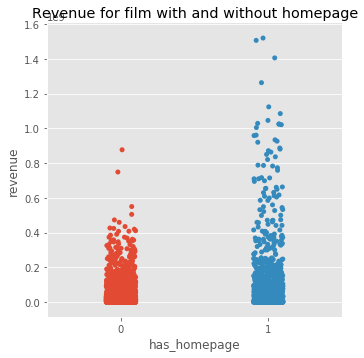

In [ ]:
sns.catplot(x='has_homepage', y='revenue', data=train);
plt.title('Revenue for film with and without homepage');

### (Part 1) Distribution of Languages in Film

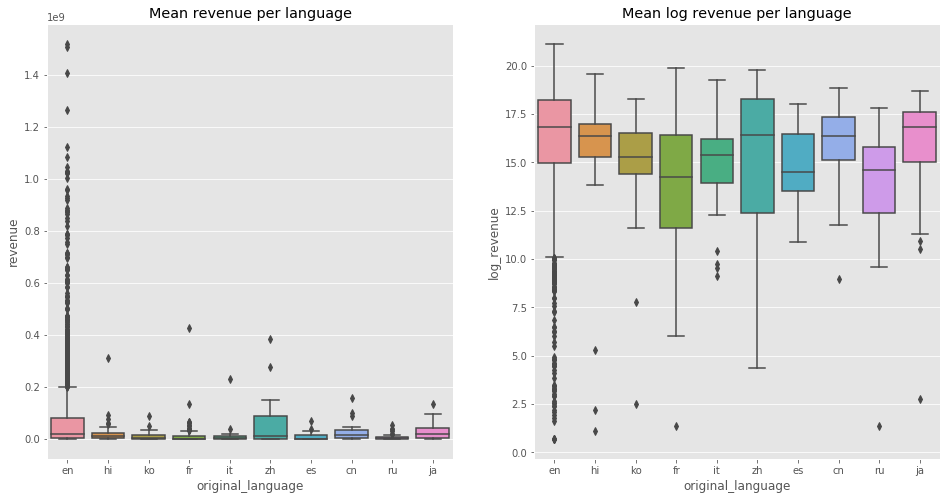

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean revenue per language');
plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='log_revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean log revenue per language');

### (Part 1) Frequent Words in Film Titles and Discriptions

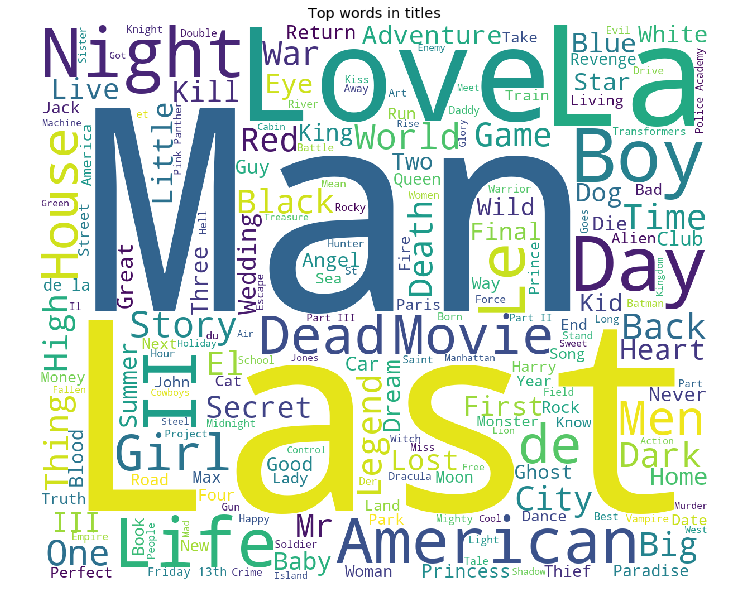

In [ ]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['original_title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

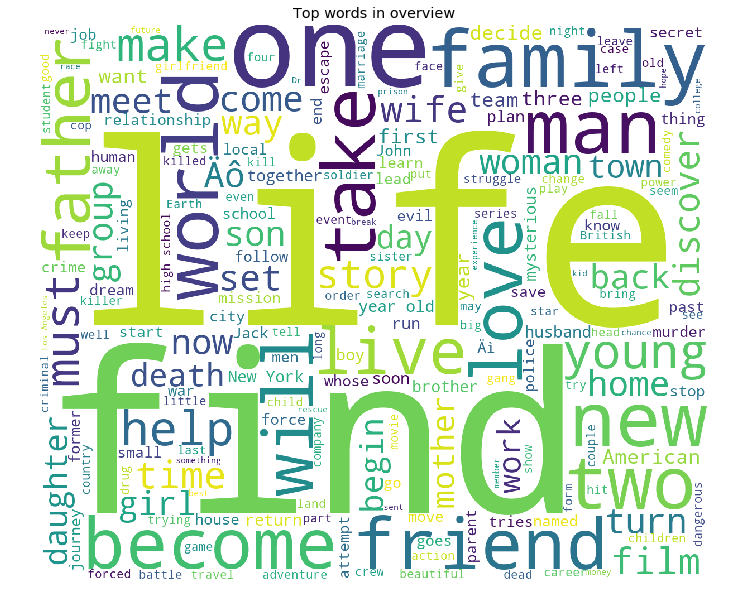

In [ ]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in overview')
plt.axis("off")
plt.show()

### (Part 1) Do Film Descriptions Impact Revenue?

In [ ]:
import eli5

vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            token_pattern=r'\w{1,}',
            ngram_range=(1, 2),
            min_df=5)

overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, train['log_revenue'])
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x != '<BIAS>')

In [ ]:
print('Target value:', train['log_revenue'][1000])
eli5.show_prediction(linreg, doc=train['overview'].values[1000], vec=vectorizer)

Target value: 16.44583954907521


###  Analyzing Movie Release Dates


In [ ]:
test.loc[test['release_date'].isnull()==False,'release_date'].head()

0    7/14/07
1    5/19/58
2    5/23/97
3     9/4/10
4    2/11/05
Name: release_date, dtype: object

###  Preprocessing Features

In [ ]:
def fix_date(x):
    year=x.split('/')[2]
    if int (year)<=19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] +'19' +year

In [ ]:
test.loc[test['release_date'].isnull()==True].head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,Keywords,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,production_company_Regency Enterprises,production_company_BBC Films,production_company_Dune Entertainment,production_company_Working Title Films,production_company_Fox Searchlight Pictures,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films,num_countries,production_country_United States of America,production_country_United Kingdom,production_country_France,production_country_Germany,production_country_Canada,production_country_India,production_country_Italy,production_country_Japan,production_country_Australia,production_country_Russia,production_country_Spain,production_country_China,production_country_Hong Kong,production_country_Ireland,production_country_Belgium,production_country_South Korea,production_country_Mexico,production_country_Sweden,production_country_New Zealand,production_country_Netherlands,production_country_Czech Republic,production_country_Denmark,production_country_Brazil,production_country_Luxembourg,production_country_South Africa,num_languages,language_English,language_Français,language_Español,language_Deutsch,language_Pусский,language_Italiano,language_日本語,language_普通话,language_हिन्दी,language_,language_Português,language_العربية,language_한국어/조선말,language_广州话 / 廣州話,language_தமிழ்,language_Polski,language_Magyar,language_Latin,language_svenska,language_ภาษาไทย,language_Český,language_עִבְרִית,language_ελληνικά,language_Türkçe,language_Dansk,language_Nederlands,language_فارسی,language_Tiếng Việt,language_اردو,language_Română,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,genders_0_cast,genders_1_cast,genders_2_cast,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank,num_crew,crew_name_Avy Kaufman,crew_name_Robert Rodriguez,crew_name_Deborah Aquila,crew_name_James Newton Howard,crew_name_Mary Vernieu,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James Horner,crew_name_Kerry Barden,crew_name_Bob Weinstein,crew_name_Harvey Weinstein,crew_name_Janet Hirshenson,genders_0_crew,genders_1_crew,genders_2_crew,jobs_Producer

In [ ]:
test.loc[test['release_date'].isnull()==True,'release_date']='05/01/00'

In [ ]:
train['release_date'].apply(lambda x: fix_date(x))
test['release_date'].apply( lambda x: fix_date(x))

0        7/14/2007
1        5/19/1958
2        5/23/1997
3         9/4/2010
4        2/11/2005
5         2/7/1996
6       12/23/2010
7        2/11/2000
8         3/2/2007
9       10/30/1999
10        9/1/2005
11       6/27/2014
12       9/10/1980
13       5/16/2002
14        9/9/2008
15       9/12/2010
16       3/26/2010
17       4/16/2014
18      12/20/1979
19      11/18/1997
20       9/11/1998
21       9/19/2008
22        9/8/2006
23       8/27/2004
24       4/15/2016
25      11/15/1991
26        7/6/1988
27      10/14/2016
28       5/16/2012
29       8/17/2001
           ...    
4368      1/1/2016
4369     3/14/2008
4370    10/15/1999
4371    11/23/2010
4372    11/22/2011
4373     11/3/1976
4374     5/24/1991
4375      9/6/2002
4376     6/22/1970
4377     9/10/2014
4378     9/16/2005
4379     4/30/2015
4380      6/3/2016
4381     3/26/1970
4382    11/23/2006
4383     9/11/2012
4384     8/14/1987
4385    12/21/2001
4386     6/28/1991
4387     9/11/2013
4388     1/30/2006
4389     3/2

###  Creating Features Based on Release Date

In [ ]:
train['release_date']= pd.to_datetime(train['release_date'],errors='coerce')
test['release_date']=pd.to_datetime(train['release_date'],errors='coerce')

In [ ]:
def process_date(df):
    date_parts=['year','weekday','month','weekofyear','day','quarter']
    for part in date_parts:
        part_col='release_date' +'_' + part
        df[part_col]=getattr(df['release_date'].dt,part).fillna(0).astype(int)
    return df
train=process_date(train)
test=process_date(test)

###  Using Plotly to Visualize the Number of Films Per Year

In [ ]:
d1= train['release_date'].value_counts().sort_index()
d2 =test['release_date'].value_counts().sort_index()

In [ ]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

data=[go.Scatter(x=d1.index,y=d1.values,name='train'),go.Scatter(x=d2.index,y=d2.values,name='test')]
layout=go.Layout(dict(title='Num of films per year',xaxis=dict(title='year'),yaxis=dict(title='Counts')),legend=dict(orientation='v'))
py.iplot(dict(data=data,layout=layout))

###  Number of Films and Revenue Per Year

In [ ]:
d1=train['release_date_year'].value_counts().sort_index()
d2=train.groupby(['release_date_year'])['revenue'].sum()
data=[go.Scatter(x=d1.index,y=d1.values,name='film_count'),go.Scatter(x=d2.index,y=d2.values,name='total_revenue',yaxis='y2')]
layout= go.Layout(dict(title='Num of films per year',xaxis=dict(title='year'),yaxis=dict(title='Counts'),yaxis2=dict(title='Total_revenue',overlapping='y',side='right')),legend=dict(orientation='v'))
py.iplot(dict(data=data,layout=layout))

ValueError: Invalid property specified for object of type plotly.graph_objs.layout.YAxis: 'overlapping'

    Valid properties:
        anchor
            If set to an opposite-letter axis id (e.g. `x2`, `y`),
            this axis is bound to the corresponding opposite-letter
            axis. If set to "free", this axis' position is
            determined by `position`.
        automargin
            Determines whether long tick labels automatically grow
            the figure margins.
        autorange
            Determines whether or not the range of this axis is
            computed in relation to the input data. See `rangemode`
            for more info. If `range` is provided, then `autorange`
            is set to False.
        calendar
            Sets the calendar system to use for `range` and `tick0`
            if this is a date axis. This does not set the calendar
            for interpreting data on this axis, that's specified in
            the trace or via the global `layout.calendar`
        categoryarray
            Sets the order in which categories on this axis appear.
            Only has an effect if `categoryorder` is set to
            "array". Used with `categoryorder`.
        categoryarraysrc
            Sets the source reference on plot.ly for  categoryarray
            .
        categoryorder
            Specifies the ordering logic for the case of
            categorical variables. By default, plotly uses "trace",
            which specifies the order that is present in the data
            supplied. Set `categoryorder` to *category ascending*
            or *category descending* if order should be determined
            by the alphanumerical order of the category names. Set
            `categoryorder` to "array" to derive the ordering from
            the attribute `categoryarray`. If a category is not
            found in the `categoryarray` array, the sorting
            behavior for that attribute will be identical to the
            "trace" mode. The unspecified categories will follow
            the categories in `categoryarray`. Set `categoryorder`
            to *total ascending* or *total descending* if order
            should be determined by the numerical order of the
            values. Similarly, the order can be determined by the
            min, max, sum, mean or median of all the values.
        color
            Sets default for all colors associated with this axis
            all at once: line, font, tick, and grid colors. Grid
            color is lightened by blending this with the plot
            background Individual pieces can override this.
        constrain
            If this axis needs to be compressed (either due to its
            own `scaleanchor` and `scaleratio` or those of the
            other axis), determines how that happens: by increasing
            the "range" (default), or by decreasing the "domain".
        constraintoward
            If this axis needs to be compressed (either due to its
            own `scaleanchor` and `scaleratio` or those of the
            other axis), determines which direction we push the
            originally specified plot area. Options are "left",
            "center" (default), and "right" for x axes, and "top",
            "middle" (default), and "bottom" for y axes.
        dividercolor
            Sets the color of the dividers Only has an effect on
            "multicategory" axes.
        dividerwidth
            Sets the width (in px) of the dividers Only has an
            effect on "multicategory" axes.
        domain
            Sets the domain of this axis (in plot fraction).
        dtick
            Sets the step in-between ticks on this axis. Use with
            `tick0`. Must be a positive number, or special strings
            available to "log" and "date" axes. If the axis `type`
            is "log", then ticks are set every 10^(n*dtick) where n
            is the tick number. For example, to set a tick mark at
            1, 10, 100, 1000, ... set dtick to 1. To set tick marks
            at 1, 100, 10000, ... set dtick to 2. To set tick marks
            at 1, 5, 25, 125, 625, 3125, ... set dtick to
            log_10(5), or 0.69897000433. "log" has several special
            values; "L<f>", where `f` is a positive number, gives
            ticks linearly spaced in value (but not position). For
            example `tick0` = 0.1, `dtick` = "L0.5" will put ticks
            at 0.1, 0.6, 1.1, 1.6 etc. To show powers of 10 plus
            small digits between, use "D1" (all digits) or "D2"
            (only 2 and 5). `tick0` is ignored for "D1" and "D2".
            If the axis `type` is "date", then you must convert the
            time to milliseconds. For example, to set the interval
            between ticks to one day, set `dtick` to 86400000.0.
            "date" also has special values "M<n>" gives ticks
            spaced by a number of months. `n` must be a positive
            integer. To set ticks on the 15th of every third month,
            set `tick0` to "2000-01-15" and `dtick` to "M3". To set
            ticks every 4 years, set `dtick` to "M48"
        exponentformat
            Determines a formatting rule for the tick exponents.
            For example, consider the number 1,000,000,000. If
            "none", it appears as 1,000,000,000. If "e", 1e+9. If
            "E", 1E+9. If "power", 1x10^9 (with 9 in a super
            script). If "SI", 1G. If "B", 1B.
        fixedrange
            Determines whether or not this axis is zoom-able. If
            true, then zoom is disabled.
        gridcolor
            Sets the color of the grid lines.
        gridwidth
            Sets the width (in px) of the grid lines.
        hoverformat
            Sets the hover text formatting rule using d3 formatting
            mini-languages which are very similar to those in
            Python. For numbers, see: https://github.com/d3/d3-form
            at/blob/master/README.md#locale_format And for dates
            see: https://github.com/d3/d3-time-
            format/blob/master/README.md#locale_format We add one
            item to d3's date formatter: "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display "09~15~23.46"
        layer
            Sets the layer on which this axis is displayed. If
            *above traces*, this axis is displayed above all the
            subplot's traces If *below traces*, this axis is
            displayed below all the subplot's traces, but above the
            grid lines. Useful when used together with scatter-like
            traces with `cliponaxis` set to False to show markers
            and/or text nodes above this axis.
        linecolor
            Sets the axis line color.
        linewidth
            Sets the width (in px) of the axis line.
        matches
            If set to another axis id (e.g. `x2`, `y`), the range
            of this axis will match the range of the corresponding
            axis in data-coordinates space. Moreover, matching axes
            share auto-range values, category lists and histogram
            auto-bins. Note that setting axes simultaneously in
            both a `scaleanchor` and a `matches` constraint is
            currently forbidden. Moreover, note that matching axes
            must have the same `type`.
        mirror
            Determines if the axis lines or/and ticks are mirrored
            to the opposite side of the plotting area. If True, the
            axis lines are mirrored. If "ticks", the axis lines and
            ticks are mirrored. If False, mirroring is disable. If
            "all", axis lines are mirrored on all shared-axes
            subplots. If "allticks", axis lines and ticks are
            mirrored on all shared-axes subplots.
        nticks
            Specifies the maximum number of ticks for the
            particular axis. The actual number of ticks will be
            chosen automatically to be less than or equal to
            `nticks`. Has an effect only if `tickmode` is set to
            "auto".
        overlaying
            If set a same-letter axis id, this axis is overlaid on
            top of the corresponding same-letter axis, with traces
            and axes visible for both axes. If False, this axis
            does not overlay any same-letter axes. In this case,
            for axes with overlapping domains only the highest-
            numbered axis will be visible.
        position
            Sets the position of this axis in the plotting space
            (in normalized coordinates). Only has an effect if
            `anchor` is set to "free".
        range
            Sets the range of this axis. If the axis `type` is
            "log", then you must take the log of your desired range
            (e.g. to set the range from 1 to 100, set the range
            from 0 to 2). If the axis `type` is "date", it should
            be date strings, like date data, though Date objects
            and unix milliseconds will be accepted and converted to
            strings. If the axis `type` is "category", it should be
            numbers, using the scale where each category is
            assigned a serial number from zero in the order it
            appears.
        rangemode
            If "normal", the range is computed in relation to the
            extrema of the input data. If *tozero*`, the range
            extends to 0, regardless of the input data If
            "nonnegative", the range is non-negative, regardless of
            the input data. Applies only to linear axes.
        scaleanchor
            If set to another axis id (e.g. `x2`, `y`), the range
            of this axis changes together with the range of the
            corresponding axis such that the scale of pixels per
            unit is in a constant ratio. Both axes are still
            zoomable, but when you zoom one, the other will zoom
            the same amount, keeping a fixed midpoint. `constrain`
            and `constraintoward` determine how we enforce the
            constraint. You can chain these, ie `yaxis:
            {scaleanchor: *x*}, xaxis2: {scaleanchor: *y*}` but you
            can only link axes of the same `type`. The linked axis
            can have the opposite letter (to constrain the aspect
            ratio) or the same letter (to match scales across
            subplots). Loops (`yaxis: {scaleanchor: *x*}, xaxis:
            {scaleanchor: *y*}` or longer) are redundant and the
            last constraint encountered will be ignored to avoid
            possible inconsistent constraints via `scaleratio`.
            Note that setting axes simultaneously in both a
            `scaleanchor` and a `matches` constraint is currently
            forbidden.
        scaleratio
            If this axis is linked to another by `scaleanchor`,
            this determines the pixel to unit scale ratio. For
            example, if this value is 10, then every unit on this
            axis spans 10 times the number of pixels as a unit on
            the linked axis. Use this for example to create an
            elevation profile where the vertical scale is
            exaggerated a fixed amount with respect to the
            horizontal.
        separatethousands
            If "true", even 4-digit integers are separated
        showdividers
            Determines whether or not a dividers are drawn between
            the category levels of this axis. Only has an effect on
            "multicategory" axes.
        showexponent
            If "all", all exponents are shown besides their
            significands. If "first", only the exponent of the
            first tick is shown. If "last", only the exponent of
            the last tick is shown. If "none", no exponents appear.
        showgrid
            Determines whether or not grid lines are drawn. If
            True, the grid lines are drawn at every tick mark.
        showline
            Determines whether or not a line bounding this axis is
            drawn.
        showspikes
            Determines whether or not spikes (aka droplines) are
            drawn for this axis. Note: This only takes affect when
            hovermode = closest
        showticklabels
            Determines whether or not the tick labels are drawn.
        showtickprefix
            If "all", all tick labels are displayed with a prefix.
            If "first", only the first tick is displayed with a
            prefix. If "last", only the last tick is displayed with
            a suffix. If "none", tick prefixes are hidden.
        showticksuffix
            Same as `showtickprefix` but for tick suffixes.
        side
            Determines whether a x (y) axis is positioned at the
            "bottom" ("left") or "top" ("right") of the plotting
            area.
        spikecolor
            Sets the spike color. If undefined, will use the series
            color
        spikedash
            Sets the dash style of lines. Set to a dash type string
            ("solid", "dot", "dash", "longdash", "dashdot", or
            "longdashdot") or a dash length list in px (eg
            "5px,10px,2px,2px").
        spikemode
            Determines the drawing mode for the spike line If
            "toaxis", the line is drawn from the data point to the
            axis the  series is plotted on. If "across", the line
            is drawn across the entire plot area, and supercedes
            "toaxis". If "marker", then a marker dot is drawn on
            the axis the series is plotted on
        spikesnap
            Determines whether spikelines are stuck to the cursor
            or to the closest datapoints.
        spikethickness
            Sets the width (in px) of the zero line.
        tick0
            Sets the placement of the first tick on this axis. Use
            with `dtick`. If the axis `type` is "log", then you
            must take the log of your starting tick (e.g. to set
            the starting tick to 100, set the `tick0` to 2) except
            when `dtick`=*L<f>* (see `dtick` for more info). If the
            axis `type` is "date", it should be a date string, like
            date data. If the axis `type` is "category", it should
            be a number, using the scale where each category is
            assigned a serial number from zero in the order it
            appears.
        tickangle
            Sets the angle of the tick labels with respect to the
            horizontal. For example, a `tickangle` of -90 draws the
            tick labels vertically.
        tickcolor
            Sets the tick color.
        tickfont
            Sets the tick font.
        tickformat
            Sets the tick label formatting rule using d3 formatting
            mini-languages which are very similar to those in
            Python. For numbers, see: https://github.com/d3/d3-form
            at/blob/master/README.md#locale_format And for dates
            see: https://github.com/d3/d3-time-
            format/blob/master/README.md#locale_format We add one
            item to d3's date formatter: "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display "09~15~23.46"
        tickformatstops
            A tuple of
            plotly.graph_objects.layout.yaxis.Tickformatstop
            instances or dicts with compatible properties
        tickformatstopdefaults
            When used in a template (as
            layout.template.layout.yaxis.tickformatstopdefaults),
            sets the default property values to use for elements of
            layout.yaxis.tickformatstops
        ticklen
            Sets the tick length (in px).
        tickmode
            Sets the tick mode for this axis. If "auto", the number
            of ticks is set via `nticks`. If "linear", the
            placement of the ticks is determined by a starting
            position `tick0` and a tick step `dtick` ("linear" is
            the default value if `tick0` and `dtick` are provided).
            If "array", the placement of the ticks is set via
            `tickvals` and the tick text is `ticktext`. ("array" is
            the default value if `tickvals` is provided).
        tickprefix
            Sets a tick label prefix.
        ticks
            Determines whether ticks are drawn or not. If "", this
            axis' ticks are not drawn. If "outside" ("inside"),
            this axis' are drawn outside (inside) the axis lines.
        tickson
            Determines where ticks and grid lines are drawn with
            respect to their corresponding tick labels. Only has an
            effect for axes of `type` "category" or
            "multicategory". When set to "boundaries", ticks and
            grid lines are drawn half a category to the left/bottom
            of labels.
        ticksuffix
            Sets a tick label suffix.
        ticktext
            Sets the text displayed at the ticks position via
            `tickvals`. Only has an effect if `tickmode` is set to
            "array". Used with `tickvals`.
        ticktextsrc
            Sets the source reference on plot.ly for  ticktext .
        tickvals
            Sets the values at which ticks on this axis appear.
            Only has an effect if `tickmode` is set to "array".
            Used with `ticktext`.
        tickvalssrc
            Sets the source reference on plot.ly for  tickvals .
        tickwidth
            Sets the tick width (in px).
        title
            plotly.graph_objects.layout.yaxis.Title instance or
            dict with compatible properties
        titlefont
            Deprecated: Please use layout.yaxis.title.font instead.
            Sets this axis' title font. Note that the title's font
            used to be customized by the now deprecated `titlefont`
            attribute.
        type
            Sets the axis type. By default, plotly attempts to
            determined the axis type by looking into the data of
            the traces that referenced the axis in question.
        uirevision
            Controls persistence of user-driven changes in axis
            `range`, `autorange`, and `title` if in `editable:
            true` configuration. Defaults to `layout.uirevision`.
        visible
            A single toggle to hide the axis while preserving
            interaction like dragging. Default is true when a
            cheater plot is present on the axis, otherwise false
        zeroline
            Determines whether or not a line is drawn at along the
            0 value of this axis. If True, the zero line is drawn
            on top of the grid lines.
        zerolinecolor
            Sets the line color of the zero line.
        zerolinewidth
            Sets the width (in px) of the zero line.
        

### Do Release Days Impact Revenue?

Text(0.5, 1.0, 'Revenue of diif days of week')

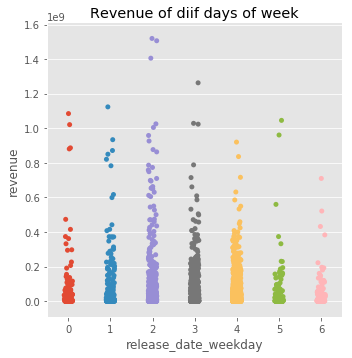

In [ ]:
sns.catplot(x='release_date_weekday',y='revenue',data=train)
plt.title('Revenue of diif days of week')

### Task 8: Relationship between Runtime and Revenue

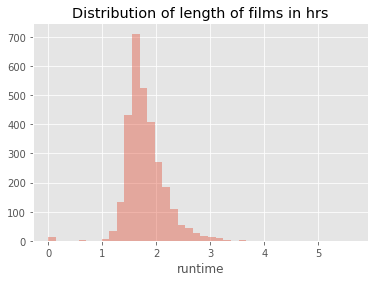

In [ ]:
sns.distplot(train['runtime'].fillna(0)/60,bins=40,kde=False);
plt.title('Distribution of length of films in hrs');

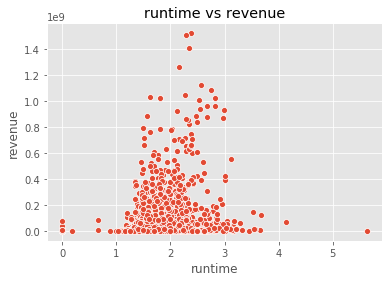

In [ ]:
sns.scatterplot(train['runtime'].fillna(0)/60, train['revenue']);
plt.title('runtime vs revenue');